In [1]:
import numpy as np
import cv2
import dlib
import os
import math
from sklearn import svm
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix    
from sklearn.externals import joblib
from threading import Thread
import imutils

# Function that returns the distance between two given points
def ptDist(pt1, pt2):
    x1 = pt1[0]
    x2 = pt2[0]
    y1 = pt1[1]
    y2 = pt2[1]
    return math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2)) 

def get17LMA(img, predictor, detector):
    LMA = []
    
    # Detect face(s)
    dets = detector(img, 1)

    # Get list of coordinates of 68 facial landmarks for each face
    if len(dets)>0:
        shape = predictor(img, dets[0])
        for index in range(0, 17):
            point = shape.part(index)
            tuplepoint = (point.x, point.y)
            LMA.append(tuplepoint)
        return LMA
    else:
        return None
    
def getPhysDA(iLA):
    PDA = []
    PDA.append(ptDist(iLA[2], iLA[3])) #distance 0: distance between brows
    PDA.append(ptDist(iLA[2], iLA[4])) #distance 1: inner brow to nose- left
    PDA.append(ptDist(iLA[3], iLA[4])) #distance 2: inner brow to nose- right
    PDA.append(ptDist(iLA[2], iLA[6])) #distance 3: inner brow to inner eye corner- left
    PDA.append(ptDist(iLA[3], iLA[7])) #distance 4: inner brow to inner eye corner- right
    PDA.append(ptDist(iLA[5], iLA[11])) #distance 5: outer eye corner to outer mouth corner- left
    PDA.append(ptDist(iLA[8], iLA[12])) #distance 6: outer eye corner to outer mouth corner- right
    PDA.append(ptDist(iLA[11], iLA[12])) #distance 7: distance between mouth corners
    PDA.append(ptDist(iLA[15], iLA[16])) #distance 8: height of mouth
    PDA.append(ptDist(iLA[5], iLA[13])) #distance 9: raising of upper lip
    PDA.append(ptDist(iLA[7], iLA[14])) #distance 10: raising of upper lip
    PDA.append(ptDist(iLA[0], iLA[9])) #distance 11: brow arch- left
    PDA.append(ptDist(iLA[1], iLA[10])) #distance 12: brow arch- right
    return np.asarray(PDA)
    
class WebcamVideoStream:
    def __init__(self, src=0):
        # initialize the video camera stream and read the first frame
        # from the stream
        self.stream = cv2.VideoCapture(src)
        (self.grabbed, self.frame) = self.stream.read()
 
        # initialize the variable used to indicate if the thread should
        # be stopped
        self.stopped = False
    def start(self):
        # start the thread to read frames from the video stream
        Thread(target=self.update, args=()).start()
        return self
 
    def update(self):
        # keep looping infinitely until the thread is stopped
        while True:
            # if the thread indicator variable is set, stop the thread
            if self.stopped:
                return
 
            # otherwise, read the next frame from the stream
            (self.grabbed, self.frame) = self.stream.read()
 
    def read(self):
        # return the frame most recently read
        return self.frame
 
    def stop(self):
        # indicate that the thread should be stopped
        self.stopped = True

In [2]:
def browTrain(IB, bV, label, RL, predictor, detector, vs):
    B_ANGLE = IB
    baseVector = bV
    STEP = 4
    N_REWARD = 0
    L_REWARD = 0
    NB = 0
    GRAD_SIGN = 1
    polyCLF = joblib.load('theModel.pkl')
    RList = RL
    
    """CALCULATE INITIAL LOSS"""
    # Initialize ARGO Face
    !ssh pi@192.168.1.119 "echo 6=$B_ANGLE > /dev/servoblaster"
    !ssh pi@192.168.1.119 "echo 3=$L_ANGLE > /dev/servoblaster"
    !ssh pi@192.168.1.119 "echo 4=$R_ANGLE > /dev/servoblaster"

    # Capture and display frame with 17 landmarks
    lm1 = None
    while lm1 == None:
        brow1 = vs.read()
        brow1 = imutils.resize(brow1, width=400)
        lm1 = get17LMA(brow1, predictor, detector)
    for i in range(17):
            cv2.circle(brow1, (lm1[i][0], lm1[i][1]), 2, (0, 0, 255), -1)
    cv2.imshow('brow1',brow1)

    # Get probabilities
    prediction = polyCLF.predict_proba(np.asarray(baseVector-getPhysDA(lm1)).reshape(1,-1))
    
    # Calculate loss
    L_REWARD = prediction[0][label]
    RList.append(L_REWARD)
    
    """TRAIN ITERATIVELY TO MAXIMIZE REWARD"""
    for j in range(0, 20):
        # Adjust step and angle
        if j==10:
            STEP=STEP/2
        if j==15:
            STEP=STEP/2
        if STEP < 1:
            STEP = 1
        NB = B_ANGLE + STEP*GRAD_SIGN
        !ssh pi@192.168.1.119 "echo 6=$NB > /dev/servoblaster"

        # Get image
        lm2 = None
        while lm2 == None:
            brow2 = vs.read()
            brow2 = imutils.resize(brow2, width=400)
            lm2 = get17LMA(brow2, predictor, detector)
        for i in range(17):
                cv2.circle(brow2, (lm2[i][0], lm2[i][1]), 2, (0, 0, 255), -1)
        cv2.imshow('brow2',brow2)
        
        # Get probabilities
        prediction = polyCLF.predict_proba(np.asarray(baseVector-getPhysDA(lm2)).reshape(1,-1))

        # Calculate loss
        N_REWARD = prediction[0][label]
        print(prediction[0])
        
        # Adjust for next iteration
        GRAD_SIGN = int(np.sign((N_REWARD-L_REWARD)/STEP))
        L_REWARD=N_REWARD
        RList.append(L_REWARD)
        B_ANGLE = NB
    return B_ANGLE, L_REWARD, RList



def mouthTrain(IL, IR, bV, label, L_REW, RL, predictor, detector, vs):
    L_ANGLE = IL
    R_ANGLE = IR
    baseVector = bV
    STEP = 4
    N_REWARD = 0
    L_REWARD = L_REW
    NL = 0
    NR = 0
    GRAD_SIGN = 1
    polyCLF = joblib.load('theModel.pkl')
    RList = RL

    for j in range(0, 20): 
        # Adjust step and angle
        if j==10:
            STEP=STEP/2
        if j==15:
            STEP=STEP/2
        if STEP < 1:
            STEP = 1
        NL = L_ANGLE - STEP*GRAD_SIGN
        NR = R_ANGLE + STEP*GRAD_SIGN
        !ssh pi@192.168.1.119 "echo 3=$L_ANGLE > /dev/servoblaster"
        !ssh pi@192.168.1.119 "echo 4=$R_ANGLE > /dev/servoblaster"

        # Get image
        lm3 = None
        while lm3 == None:
            mouth = vs.read()
            mouth = imutils.resize(mouth, width=400)
            lm3 = get17LMA(mouth, predictor, detector)
        for i in range(17):
                cv2.circle(mouth, (lm3[i][0], lm3[i][1]), 2, (0, 0, 255), -1)
        cv2.imshow('mouth',mouth)

        
        # Get probabilities
        prediction = polyCLF.predict_proba(np.asarray(baseVector-getPhysDA(lm3)).reshape(1,-1))
        
        # Calculate loss
        N_REWARD = prediction[0][label]
        print(prediction[0])
        
        # Adjust for next iteration
        GRAD_SIGN = int(np.sign((N_REWARD-L_REWARD)/STEP))
        L_REWARD=N_REWARD
        RList.append(L_REWARD)
        L_ANGLE = NL
        R_ANGLE = NR

#     cv2.destroyAllWindows()
    return L_ANGLE, R_ANGLE, L_REWARD, RList

In [3]:
###### TRAINING THE GENERATIVE MODEL ######
# 
#
#  HAPPINESS TRAINING 
#
#
############################################

import numpy as np
import cv2
import dlib
import os
import math
from sklearn import svm
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix    
from sklearn.externals import joblib

"""Initialize Variables"""
B_ANGLE = 100
L_ANGLE = 160
R_ANGLE = 100
L_REWARD = 0
InitRew_List = []

predictor_path = "/Users/kaili/dlib/examples/build/sp.dat"
detector = dlib.fhog_object_detector("/Users/kaili/dlib/examples/build/face_detector.svm")
predictor = dlib.shape_predictor(predictor_path)


#####################
# BASELINE
####################
INITIAL_B_ANGLE = 140
INITIAL_L_ANGLE = 120
INITIAL_R_ANGLE = 135
!ssh pi@192.168.1.119 "echo 6=$INITIAL_B_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 3=$INITIAL_L_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 4=$INITIAL_R_ANGLE > /dev/servoblaster"
vs = WebcamVideoStream(src=0).start()
bvec = None
while bvec == None:
    baseline = vs.read()
    baseline = imutils.resize(baseline, width=640)
    bvec = get17LMA(baseline,predictor,detector)
baseVector = getPhysDA(bvec)


############
# EYEBROW TRAINING
############
B_ANGLE, L_REWARD, InitRew_List = browTrain(B_ANGLE, baseVector, 0, InitRew_List, predictor, detector, vs)
print("browsdone")

############
# MOUTH CORNER TRAINING
############
L_ANGLE, R_ANGLE, L_REWARD, Rew_List = mouthTrain(L_ANGLE, R_ANGLE, baseVector, 0, L_REWARD, InitRew_List, predictor, detector, vs)

############
# CLEANUP AND RESULTS
############
vs.stop()
print("Brow Servo: "+str(B_ANGLE))
print("Left Servo: "+str(L_ANGLE))
print("Right Servo: "+str(R_ANGLE))
print("Maximum Probability: " + str(L_REWARD))
print("Anger All Rewards: ")
print(Rew_List)



[ 0.92909729  0.00454095  0.00679893  0.00226002  0.04874914  0.00517037
  0.0033833 ]
[ 0.54090373  0.05408601  0.08104156  0.02698192  0.19087189  0.06565023
  0.04046466]
[ 0.95424436  0.00224438  0.00336287  0.00111905  0.03460787  0.00274492
  0.00167654]
[ 0.63279235  0.039507    0.05920894  0.01971747  0.16915209  0.05005163
  0.02957052]
[ 0.39402587  0.07601679  0.11390539  0.03792518  0.23233654  0.08890019
  0.05689004]
[ 0.92575694  0.0047462   0.00710562  0.00236151  0.05076721  0.00572773
  0.00353479]
[  9.89567030e-01   2.41392126e-04   3.62086480e-04   1.20705098e-04
   9.33784308e-03   2.48028622e-04   1.22914221e-04]
[ 0.48108354  0.06296518  0.09434001  0.03140752  0.20760581  0.0754939
  0.04710404]
[  9.88365358e-01   2.94176215e-04   4.41261844e-04   1.47101474e-04
   1.03153558e-02   2.86413347e-04   1.50333453e-04]
[ 0.55187235  0.0536368   0.08037256  0.02676026  0.18303716  0.06418875
  0.04013211]
[ 0.34765315  0.0845489   0.12671019  0.04219734  0.23824378 

In [7]:
print(Rew_List)

[0.85873969073004708, 0.92909728930915647, 0.5409037251616069, 0.95424436194381734, 0.63279235215365548, 0.39402587150393276, 0.92575693975827711, 0.98956703037721017, 0.48108354179841895, 0.98836535788366364, 0.55187235396660361, 0.34765315083475684, 0.9825378551309073, 0.63158883707108038, 0.69036071103281882, 0.92317006835563775, 0.98426290484660672, 0.72946168658949861, 0.95942367385910565, 0.92898496814439624, 0.99023292052634937, 0.94328204246405267, 0.95839871763397044, 0.70602479633645288, 0.97433539027220084, 0.97306004127184997, 0.99772324818524005, 0.69312932933741012, 0.98664210817566567, 0.98962226897470296, 0.81580951331724194, 0.91227704536117615, 0.93001249488545357, 0.93385677017312385, 0.87196127109308263, 0.97733488382937461, 0.95805191325669559, 0.99339015281038179, 0.96850832500487893, 0.99368909609285228, 0.96052553688708431]


In [4]:
import json
with open("HappinessRewards","w") as wfile:
    json.dump(Rew_List,wfile)

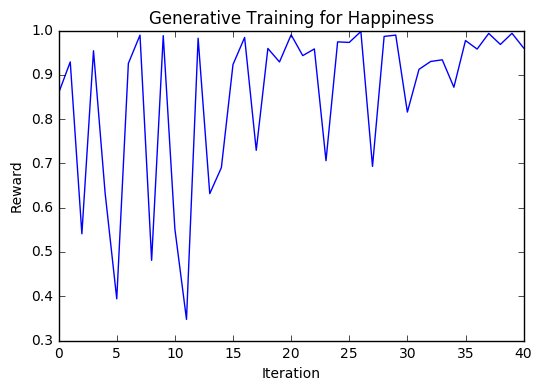

In [6]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0,41)

plt.plot(x, Rew_List)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Generative Training for Happiness")
plt.savefig("HRewT.png")
plt.show()

In [ ]:
###### TRAINING THE GENERATIVE MODEL ######
# 
#
#  SADNESS TRAINING 
#
#
############################################

import numpy as np
import cv2
import dlib
import os
import math
from sklearn import svm
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix    
from sklearn.externals import joblib


"""Load SVM"""
polyCLF = joblib.load('theModel.pkl')

"""Initialize Variables"""
B_ANGLE = 100
L_ANGLE = 100
R_ANGLE = 170
L_REWARD = 0
InitRew_List = []

#####################
# BASELINE
####################
INITIAL_B_ANGLE = 140
INITIAL_L_ANGLE = 120
INITIAL_R_ANGLE = 135
!ssh pi@192.168.1.119 "echo 6=$INITIAL_B_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 3=$INITIAL_L_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 4=$INITIAL_R_ANGLE > /dev/servoblaster"
vs = WebcamVideoStream(src=0).start()
baseline = vs.read()
baseline = imutils.resize(baseline, width=400)
baseVector = getPhysDA(get17LMA(baseline))
vs.stop()

############
# EYEBROW TRAINING
############
B_ANGLE, L_REWARD, InitRew_List = browTrain(B_ANGLE, baseVector, 5, InitRew_List)


############
# MOUTH CORNER TRAINING
############
L_ANGLE, R_ANGLE, L_REWARD, Rew_List = mouthTrain(L_ANGLE, R_ANGLE, baseVector, 5, L_REWARD, InitRew_List)

############
# CLEANUP AND RESULTS
############
cv2.destroyAllWindows()
cv2.waitKey(1)
print("Brow Servo: "+str(B_ANGLE))
print("Left Servo: "+str(L_ANGLE))
print("Right Servo: "+str(R_ANGLE))
print("Maximum Probability: " + str(L_REWARD))
print("Sadness All Rewards: " + Rew_List)

In [ ]:
###### TRAINING THE GENERATIVE MODEL ######
# 
#
#  SURPRISE TRAINING 
#
#
############################################

import numpy as np
import cv2
import dlib
import os
import math
from sklearn import svm
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix    
from sklearn.externals import joblib


"""Load SVM"""
polyCLF = joblib.load('theModel.pkl')

"""Initialize Variables"""
B_ANGLE = 100
L_ANGLE = 120
R_ANGLE = 140
L_REWARD = 0
InitRew_List = []

#####################
# BASELINE
####################
INITIAL_B_ANGLE = 140
INITIAL_L_ANGLE = 120
INITIAL_R_ANGLE = 135
!ssh pi@192.168.1.119 "echo 6=$INITIAL_B_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 3=$INITIAL_L_ANGLE > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 4=$INITIAL_R_ANGLE > /dev/servoblaster"
vs = WebcamVideoStream(src=0).start()
baseline = vs.read()
baseline = imutils.resize(baseline, width=400)
baseVector = getPhysDA(get17LMA(baseline))
vs.stop()

############
# EYEBROW TRAINING
############
B_ANGLE, L_REWARD, InitRew_List = browTrain(B_ANGLE, baseVector, 6, InitRew_List)


############
# MOUTH CORNER TRAINING
############
L_ANGLE, R_ANGLE, L_REWARD, Rew_List = mouthTrain(L_ANGLE, R_ANGLE, baseVector, 6, L_REWARD, InitRew_List)

############
# CLEANUP AND RESULTS
############
cv2.destroyAllWindows()
cv2.waitKey(1)
print("Brow Servo: "+str(B_ANGLE))
print("Left Servo: "+str(L_ANGLE))
print("Right Servo: "+str(R_ANGLE))
print("Maximum Probability: " + str(L_REWARD))
print("Surprise All Rewards: " + Rew_List)

In [4]:
!ssh pi@192.168.1.119 "echo 6=$100 > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 3=$160 > /dev/servoblaster"
!ssh pi@192.168.1.119 "echo 4=$100 > /dev/servoblaster"

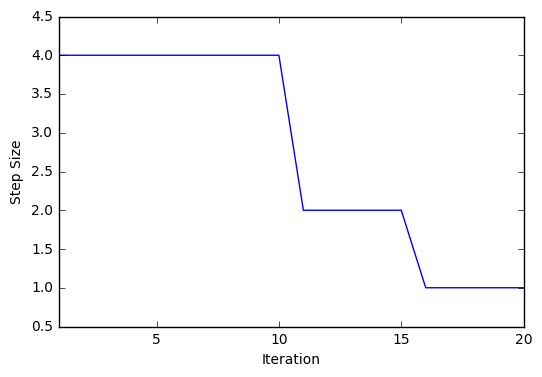

In [13]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,21)
y = [4,4,4,4,4,4,4,4,4,4,2,2,2,2,2,1,1,1,1,1]
plt.xlabel("Iteration")
plt.ylabel("Step Size")
x1,x2,y1,y2 = plt.axis()
plt.axis((1,20,0.5,4.5))
plt.plot(x,y)
plt.savefig("Step Size Diagram.png")
plt.show()